In [1]:
from plot_utils import *
import pandas as pd
import numpy as np
import datetime
import os


Text(0.5, 0.01, 'IF iteration')

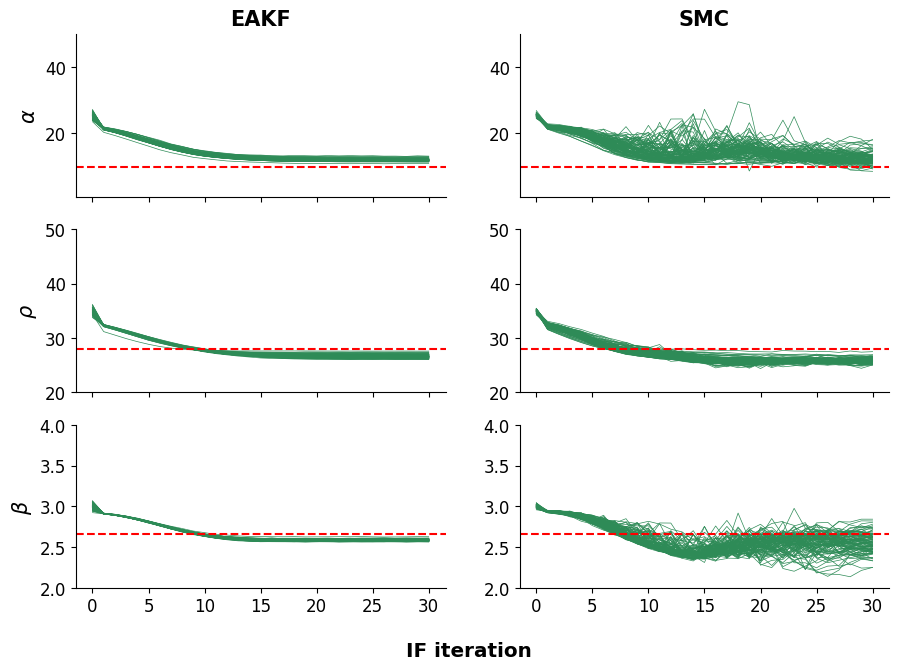

In [15]:
results_dir = 'results'

eakf_dir = os.path.join(results_dir, 'eakf')
pf_dir   = os.path.join(results_dir, 'inference', 'pf')



αmin = 1
αmax = 50

ρmin = 20
ρmax = 50

βmin = 2
βmax = 4
parameters_range  = np.array([[αmin, αmax],
                              [ρmin, ρmax],
                              [βmin, βmax]])
θ_truth = [10, 28, 8/3]

fig, ax = plt.subplots(3, 2, figsize=(10.5, 7.2), sharex=True)

for i in range(1, 99):

    i_file     = str(i).zfill(3)
    infer_file = os.path.join(eakf_dir, '{}_infer.npz'.format(i_file))

    infer = np.load(infer_file)
    θmle  = infer['θmle']

    ax[0, 0].plot(range(30+1), θmle[0, :], label='True', color="seagreen", lw=0.5)
    ax[1, 0].plot(range(30+1), θmle[1, :], label='True', color="seagreen", lw=0.5)
    ax[2, 0].plot(range(30+1), θmle[2, :], label='True', color="seagreen", lw=0.5)

    infer_file = os.path.join(pf_dir, '{}_infer.npz'.format(i_file))
    infer = np.load(infer_file)
    θmle  = infer['θmle']

    ax[0, 1].plot(range(30+1), θmle[0, :], label='True', color="seagreen", lw=0.5)
    ax[1, 1].plot(range(30+1), θmle[1, :], label='True', color="seagreen", lw=0.5)
    ax[2, 1].plot(range(30+1), θmle[2, :], label='True', color="seagreen", lw=0.5)

p_label = ['α', 'ρ', 'β']
for p in range(3):
    ax[p,0].axhline(y=θ_truth[p], color='red', ls='--')
    ax[p,0].set_ylim(parameters_range[p])
    ax[p,1].axhline(y=θ_truth[p], color='red', ls='--')
    ax[p,1].set_ylim(parameters_range[p])

    ax[p, 0].set_ylabel(r'${}$'.format(p_label[p]))

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[0, 0].set_title('EAKF', weight="bold", fontsize=15)
ax[0, 1].set_title('SMC', weight="bold", fontsize=15)

fig.supxlabel("IF iteration", weight='bold')